# Final Report

## Introduction

In the ever-evolving world of online games, understanding player behavior is critical for developing engaging experiences and effective communication strategies. One emerging area of interest lies in examining the ways in which in-game behavior and demographic information might predict a player’s engagement outside of gameplay—such as subscribing to a game-related newsletter. This connection between in-game actions and out-of-game engagement can offer valuable insights for both game developers and researchers interested in player psychology and behavior modeling.

The specific question we aim to answer in this project is: *Can playing duration and age be used to predict whether a player subscribes to a game-related newsletter, and does their in-game experience affect this outcome?* This question sits within a broader exploration of which player characteristics and behaviors are most predictive of newsletter subscription, and how these predictors may differ across various types of players. The motivation behind this question stems from a desire to bridge the gap between in-game analytics and marketing efforts, with the hope of improving player communication through data-driven strategies.

To address this question, we will analyze data from the players.csv file provided by the Minecraft research server project. This dataset contains 7 variables and 196 observations, representing player experience, subscription status, hashed email, total playtime, name, gender, and age. The hashed emails and names are irrelevant as they do not contribute to answering the question. A potential issue in the gender variable is the presence of "Prefer not to say," which may complicate gender-based analyses. Additionally, the age column has an unusually high number of 17-year-old entries due to a default setting, which may distort the actual age distribution. The most relevant variables for predicting newsletter subscription are playing duration and player experience, as they contain fewer or no significant outliers, making them ideal for identifying patterns in subscription behavior.

To answer our research question, we will select the experience, subscribe, age, and played_hours columns from the dataset. We will convert the experience column into a factor variable to allow for clear visualization, either by coloring different player types or by generating separate plots for each experience level. Due to the abundance of default values set to 17 in the age column, we will consider filtering these observations to avoid skewing the results. After cleaning the data, we will standardize the age and played_hours variables and use them in a K-Nearest Neighbors (K-NN) classification model to explore whether these features can predict newsletter subscription.


## Methods

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_data <- read_csv("https://raw.githubusercontent.com/Eueheb/DSCI_100/refs/heads/main/data/players.csv") 
head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Our analysis starts by importing the dataset directly from the data folder.

In [3]:
players_tidy <- players_data |>
  select (experience, subscribe, played_hours, Age) |>
  filter (Age != 17) |>
  mutate (experience = as_factor(experience),
        subscribe = as_factor(subscribe))
head(players_tidy)
players_tidy <- players_tidy %>%
  mutate(subscribe = fct_relevel(subscribe, "TRUE")) #This simply makes TRUE in subscribe column the positive class

experience,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
Pro,TRUE,30.3,9
Amateur,TRUE,0.7,21
Regular,TRUE,0.1,21
Regular,TRUE,0.0,19
Amateur,FALSE,0.0,21
Veteran,TRUE,0.0,22


After loading, we clean the dataset to include only the relevant variables: experience, subscribe, played_hours, and Age. These variables are chosen because they relate closely to user behavior and potential factors influencing subscription decisions. Players aged exactly 17 are removed, because they form an unrepresentative group that could introduce noise. Converting experience and subscribe to categorical types ensures that these variables are treated correctly during modeling, especially since subscribe is the outcome we aim to predict.

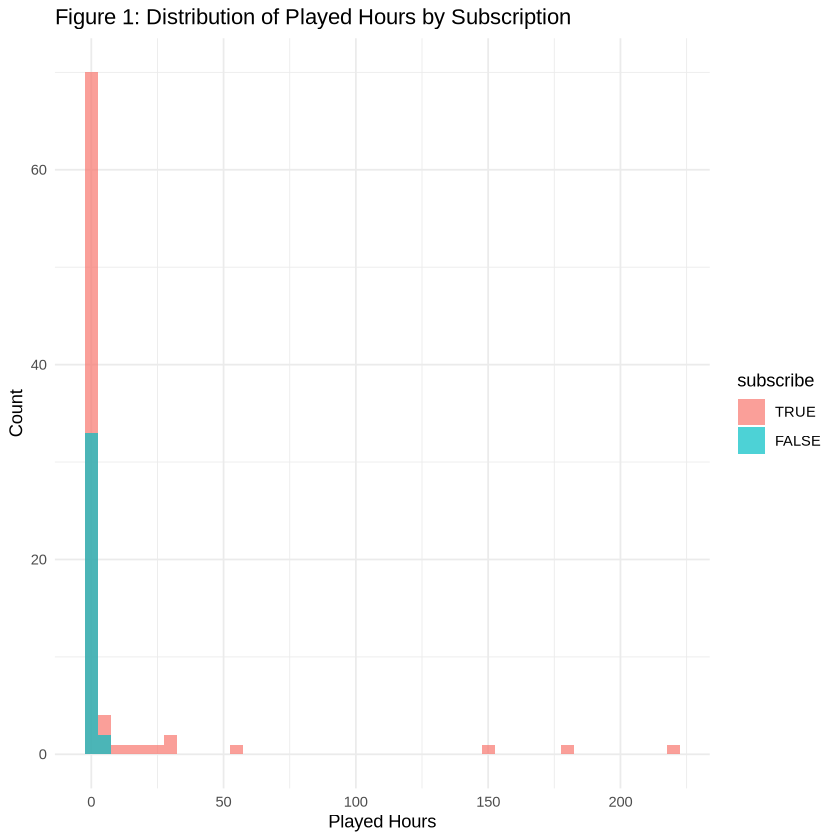

In [4]:
p1 <- players_tidy |>
  ggplot(aes(x = played_hours, fill = subscribe)) +
  geom_histogram(binwidth = 5, alpha = 0.7, position = "identity") +
  labs(title = "Figure 1: Distribution of Played Hours by Subscription",
       x = "Played Hours", y = "Count") +
  theme_minimal()
p1

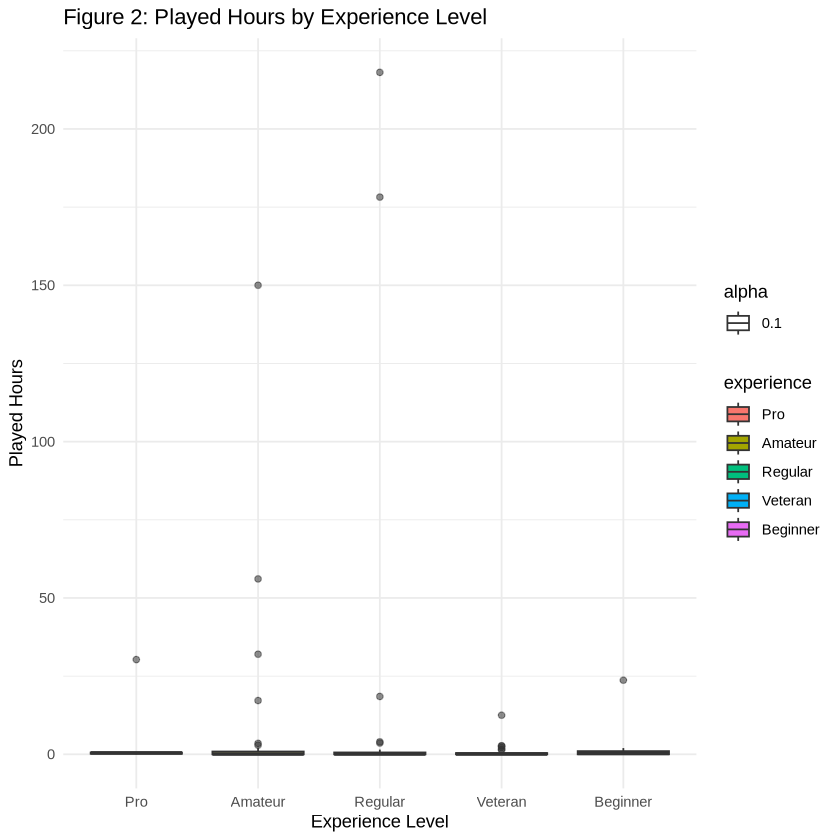

In [5]:
p2 <- players_tidy |>
  ggplot(aes(x = experience, y = played_hours, fill = experience, alpha = 0.1)) +
  geom_boxplot() +
  labs(title = "Figure 2: Played Hours by Experience Level",
       x = "Experience Level", y = "Played Hours") +
  theme_minimal()
p2

The next step involves visual exploration of the data. A histogram is created to compare how playtime is distributed across subscription statuses. This visualization provides an intuitive way to assess whether more engaged users tend to subscribe and whether there is a pattern that could inform predictions. The bin width is chosen to balance granularity and clarity. It is shown that most people does not play for over ten hours and those people who play over ten hours almost all have subscription to gaming newsletter. This may an important indicator to whether a player subscribe or not. A second plot—a boxplot—illustrates how playtime differs across experience levels. This helps us explore whether experience is related to the amount of time spent playing, which might be another indicator of subscription behavior. From the box plot, we found out that regular players spends the most time on the game and amateur players spends the second most time on the game, while other palyers having somewhat similar playing duration. Both visualizations serve to uncover possible relationships among the variables and the target, guiding feature selection and model expectations.

In [6]:
set.seed(1234)
data_split <- initial_split(players_tidy, prop = 0.8, strata = subscribe)
train_data <- training(data_split)
test_data <- testing(data_split)

The dataset is then split into training and testing sets with an 80/20 ratio. This ensures enough data is available for training while reserving a portion for final model evaluation. Stratifying by the outcome variable ensures that both subsets have similar class distributions, which is critical for classification tasks to avoid biased or misleading results.

In [7]:
knn_recipe <- recipe(subscribe ~ played_hours + Age + experience, data = train_data) |>
  step_normalize(all_numeric_predictors()) |>
  step_dummy(all_nominal_predictors())

We then create a preprocessing recipe . Normalizing numeric variables is essential because the model we’re using is sensitive to scale—larger-scale features could dominate smaller ones and distort the distance calculations. Dummy encoding is applied to the experience variable, allowing the categorical levels to be represented in a way the model can interpret and process effectively. This preprocessing ensures the model receives clean, consistent input without hidden biases from scaling or encoding mismatches.

In [8]:
knn_spec <- nearest_neighbor(neighbors = tune(), weight_func = "rectangular") |>
  set_engine("kknn") |>
  set_mode("classification")

Next, we specify the k-nearest neighbors classification model, allowing the number of neighbors (k) to be tuned. This setup is chosen because k-NN is intuitive and well-suited for problems where similarity in feature space corresponds to similar outcomes. Setting the number of neighbors as a parameter to be tuned because model performance is highly dependent on this value—too small, and the model overfits; too large, and it may underfit or smooth out important distinctions. Therefore we want to test out different k to determine which works the best.

In [9]:
knn_workflow <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(knn_recipe)

We combine the preprocessing and model definition into a single workflow. 

In [10]:
set.seed(1234)
folds <- vfold_cv(train_data, v = 10, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

To find the optimal number of neighbors, we conduct 10-fold cross-validation. This method offers a robust way to evaluate the model’s performance across various partitions of the training data. It mitigates the effects of random variation from any single train-test split and produces more stable estimates of model performance. We evaluate a range of values for k, from 1 to 20, to identify the configuration that results in the highest classification accuracy.

In [11]:
knn_tune_results <- knn_workflow |>
    tune_grid(resamples = folds, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
knn_tune_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6566667,10,0.04327988,Preprocessor1_Model01
2,accuracy,binary,0.6566667,10,0.04327988,Preprocessor1_Model02
3,accuracy,binary,0.5769444,10,0.04618886,Preprocessor1_Model03
4,accuracy,binary,0.5894444,10,0.05263431,Preprocessor1_Model04
5,accuracy,binary,0.6494444,10,0.03833333,Preprocessor1_Model05
6,accuracy,binary,0.6394444,10,0.03817196,Preprocessor1_Model06
7,accuracy,binary,0.6705556,10,0.02880865,Preprocessor1_Model07
8,accuracy,binary,0.6505556,10,0.03315229,Preprocessor1_Model08
9,accuracy,binary,0.6716667,10,0.02699451,Preprocessor1_Model09


In [12]:
best_k <- knn_tune_results |>
  arrange(-mean) |>
    slice(1) |>
    pull(neighbors)
best_k

[1] 13

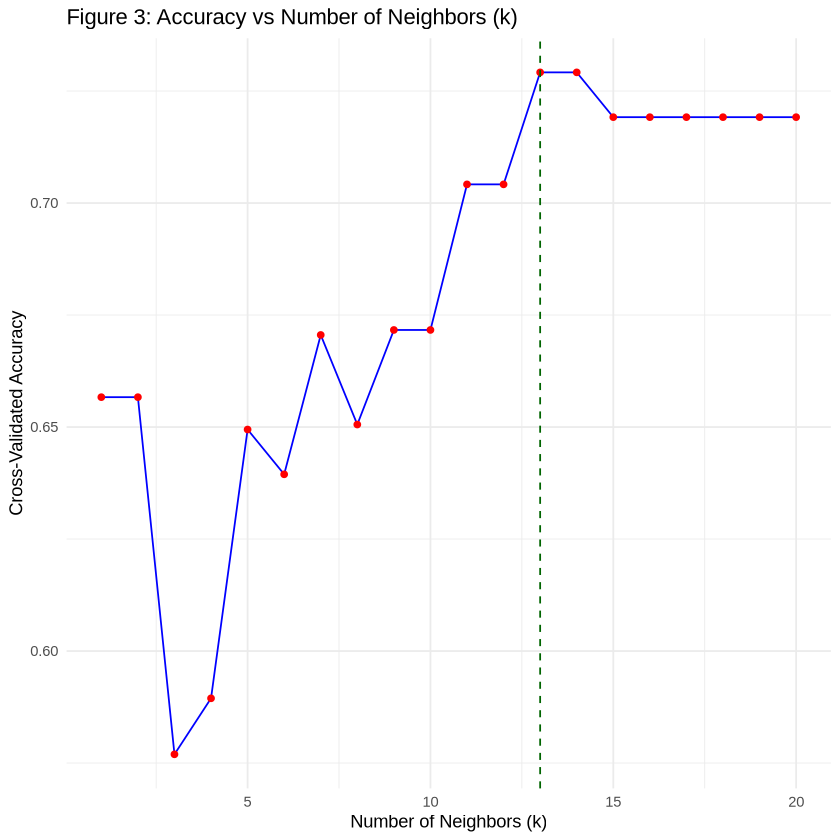

In [13]:
knn_plot <- knn_tune_results |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line(color = "blue") +
  geom_point(color = "red") +
  geom_vline(xintercept = best_k, linetype = "dashed", color = "darkgreen") +
  labs(title = "Figure 3: Accuracy vs Number of Neighbors (k)",
       x = "Number of Neighbors (k)",
       y = "Cross-Validated Accuracy") +
  theme_minimal()
knn_plot

The model is tuned across the grid of k values, and the one yielding the best accuracy across all folds is selected, which turns out to be 13. This process helps identify a balance between model flexibility and stability. Visualizing the tuning results as a line plot makes it easy to interpret how accuracy changes with the number of neighbors. The plot reveals whether performance improves or plateaus and helps justify the selection of the best k. As shown in the figure, the best k is 13 because it has the highest accuracy.

In [14]:
final_knn_spec <- nearest_neighbor(neighbors = best_k, weight_func = "rectangular") |>
  set_engine("kknn") |>
  set_mode("classification")

final_knn_workflow <- workflow() |>
  add_model(final_knn_spec) |>
  add_recipe(knn_recipe)

final_fit <- fit(final_knn_workflow, data = train_data)

test_accuracy <- predict(final_fit, test_data) |>
  bind_cols(test_data) |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

test_precision <- predict(final_fit, test_data) |>
  bind_cols(test_data) |>
  precision(truth = subscribe, estimate = .pred_class)

test_recall <- predict(final_fit, test_data) |>
  bind_cols(test_data) |>
  recall(truth = subscribe, estimate = .pred_class)

test_accuracy

test_precision

test_recall

confusion_matrix <- predict(final_fit, test_data) |>
  bind_cols(test_data) |>
  conf_mat(truth = subscribe, estimate = .pred_class)

confusion_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7619048


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9411765


          Truth
Prediction TRUE FALSE
     TRUE    16     5
     FALSE    1     2

With the optimal value chosen, the workflow is finalized and retrained on the full training dataset. This ensures that the model benefits from all available training data before making final predictions. The model is then applied to the test set, providing an unbiased evaluation of its real-world performance. The results include  overall accuracy, precision, recall and a confusion matrix, offering insight into how well the model predicts each class and where it might make mistakes. This final step validates the effectiveness of the model and helps us understand its strengths and limitations in a practical context.

## Discusion & Results

This project explored whether a player's age and playing duration can predict their likelihood of subscribing to a game-related newsletter, and whether a player’s experience level influences this outcome. Using a K-Nearest Neighbors (K-NN) classification model and cross-validation from players.csv, we found that the optimal number of neighbors was 13. The final model achieved an accuracy of 75% and a precision of 76.2%. These results indicate that the model is particularly strong at identifying actual subscribers, as seen with high recall of 94.1%. Although, it does make some incorrect predictions, as reflected by a slightly lower precision. The precision and accuracy may be improved if there is a larger data set to test and train on or if we perform more folds for cross-validation. Importantly, the inclusion of experience level as a categorical variable improved the model’s ability to distinguish patterns among different types of players. 

These findings partially align with our expectations. We predicted that longer playtime and older age would be associated with higher likelihood of subscription, and that experience level might influence this relationship. The model’s high recall supports this hypothesis. However, the lower precision suggests that subscription behavior may also depend on other factors not included in the dataset. 


The ability to predict out-of-game engagement based on in-game behavior could be valuable for game developers and marketers. If certain patterns in playtime and experience levels correlate with higher subscription rates, targeted communication strategies— such as in-game prompts or personalized offers—could be developed to encourage newsletter signups. Furthermore, this approach illustrates how behavioral analytics can enable more tailored and effective player outreach. 

Lastly, this study opens the door for further researches and questions, such as “Would adding more behavioral variables (eg. session frequency, type of gameplay) improve prediction?” or “How does subscription behavior vary across different experience levels when analyzed separately?”
